In [1]:
import scipy as sc                   # Import de scipy qui va nous permettre de solvez les porblèmes d'optimisation
import numpy as np                   # numpy toujours utile pour manipuler des vecteurs & matrices
import matplotlib.pyplot as plt      # pour graphiques éventuels
import pandas as pd                  # Import de panda pour la lecture des données dans excel 
from scipy.optimize import linprog   # Import pour avoir le solveur linprog
from mpl_toolkits.basemap import Basemap
import  time
import cvxpy as cp
import seaborn as sns

 
chemin_sites = "Data-partie-1/Sites.csv"
chemin_onshore = "Data-partie-1/Rendements_onshore.csv"
chemin_offshore = "Data-partie-1/Rendements_offshore.csv"
chemin_consomation = "Data-partie-2/Consommations.csv"
chemin_apport = "Data-partie-2/Apports-hydro.csv"  
#On créer une varaible Data pour extraire les données 
Nombre_sites = 642
#Variables pour le point 4 
C_Ion=168903 
C_Ioff=300336
turbinage = [8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101]
pompage = [5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ]   
n = 0.85
#Variables pour le point 6 
Cout_gaz = 94956
Cout_gaz_heure = 65 




## Question 4A



Modélisons le problème de la façon suivante : 


\begin{align*}
Variables/Contraintes :\\

& \text{ Soit } x_i^{on} \text{ la proportion installée } (0 \leq x_i \leq C_i \text{ (Capacité du site i)}) \text{ sur le site éolien onshore } i \text{ pour } i = 1, 2, \ldots, m, \\
& \text{ Soit } x_j^{of} \text{ la proportion installée } (0 \leq x_i \leq C_i \text{ (Capacité du site i)}) \text{ sur le site éolien ofshore } j \text{ pour } j = 1, 2, \ldots, n, \\
& \text{ Où } N \text{ est le nombre total d'heures.} \\
& \text{ Soit } y_t \text{ L'énergie pompée au temps } t \text{ pour } t = 1, 2, \ldots, N, \\
& \text{ Soit } z_t \text{ L'énergie turbinée au temps } t \text{ pour } t = 1, 2, \ldots, N, \\
& \text{ Soit } s_t \text{ Le contenu des réserves hydroélectriques au temps } t \text{ pour } t = 1, 2, \ldots, N, \\
& \text{ Où } C_i,C_j \text{ sont les capacités maximales de production des éoliennes } \\
& \text{ Où } A_t \text{ est l'apport externe à chaque heure} \\
& \text{ Où } s_t \text { est le stokage au temps t du bassin }

 
\end{align*}

\begin{align*}
Fonction \; objectif :\\

& \text{ Minimiser }  C_{Ion} (\sum_{i=1}^{m} x_{i}^{on}) + C_{Iof}(\sum_{j=1}^{n} x_{j}^{of}) , \text{ le coût de production de l'énergie à la demande } \\

\end{align*}

\begin{align*}
Contraintes : \\


& \text{ 1. Contrainte de la demande }  \\
&  \sum_{i=1}^m r_ix_{i,t}^{on} + \sum_{j=1}^n r_jx_{j,t}^{of} - y_t + \eta z_t  \geq D_t \\
& \text{2. Borne du pompage :} \\
& 0 \leq y_t \leq P_{pompage} \\
& \text{3. Borne du turbinage :} \\
& 0 \leq z_t \leq P_{turbinage} \\
& \text{4. Borne de la production onshore/offshore :} \\
& 0 \leq x_i^{on} \leq  C_i \\
& 0 \leq x_j^{of} \leq  C_j \\
& \text{5. Contrainte de dépassement du bassin : } \\
& s_t  \leq S_t \\
& \text{6. Bilan = 0} \\
& s_t = s_{t-1} + y_t - z_t + A_t \\
& s_0 = 0.5 * S_t \text{ et } s_T = 0.5 * S_t \\
\end{align*}

### Extraction des données (Partie 2)

In [2]:
class FichierData2 : 
    def __init__(self , chemin_fichier_sites , chemin_fichier_offshore , chemin_fichier_onshore , chemin_fichier_Consomation , chemin_fichier_Apport_hydro ) :
        self.Sites = pd.read_csv(rf"{chemin_fichier_sites}")
        self.offshore = pd.read_csv(rf"{chemin_fichier_offshore}" , header=None)
        self.onshore = pd.read_csv(rf"{chemin_fichier_onshore}" , header = None) 
        self.consommation = pd.read_csv(rf"{chemin_fichier_Consomation}" ,header=None)
        self.apport = pd.read_csv(rf"{chemin_fichier_Apport_hydro}" , header=None)      
        self.nombre_site  = 642 
        self.don= self.liste_ordre()
        
    def extract_Capacite(self) : 
        return self.Sites.iloc[:, 7].values
    
    #Fonction qui extrait les données pour l'onshore et l'offshore et retourne les rendements en fonction des index qui sont dans liste_ordre 
    def extract_conso(self) : 
        conso = [] 
        for i in range(len(self.consommation)) :
            conso.append(self.consommation.iloc[i].to_numpy())        
        return np.array(conso)
    
    def extract_apport(self) :
        apport = []
        for i in range(len(self.apport)) :
            apport.append(self.apport.iloc[i].to_numpy())
        return np.array(apport)

        
    
    def extract_on(self) :       
        On = []       
        for i in range(len(self.don)  ) :          
            if self.don[i][5] == "Non" : 
                index = int(self.don[i][0])
                On.append(self.onshore.iloc[index].to_numpy())      
        return np.array(On)
    
    def extract_off(self) : 
        Off = []    
        for i in range(len(self.don) ) : 
            if self.don[i][5] == "Oui" : 
                index = int(self.don[i][0] )
                Off.append(self.offshore.iloc[index].to_numpy())
        return np.array(Off)
        
    #Creation d'ue liste pour stocker les informations mais dans l'ordre(l'ordre du csv donc dabord tous les onshore puis offshore c'est plus facile pour la suite )
    def liste_ordre (self) : 
        lst = []
        for i in range (len(self.Sites)) : 
            lst.append(self.Sites.iloc[i , :8].values)       
        return np.array(lst)

## Question 4B (Modèle 4) 

In [3]:
def mod4 (Data, n, Nombre_sites, Periode, C_Ion, C_Ioff, turbinage, pompage):   
    Ron = Data.extract_on() #On extrait les données pour les Rendements onshore
    Roff = Data.extract_off() #On extrait les données pour les Rendements offShore
    Nbre_offshore = len(Roff) #On extrait le nombre de Site offshore 
    Nbre_onshore = len(Ron)
    Nbre_heure = Periode   #Le nombre d'heures total dans une année 365 * 24
    c = Data.extract_Capacite() #On extrait les capacitées 

    C_Ion = ((C_Ion )/(365*24) )* Nbre_heure
    C_Ioff = (C_Ioff /(365*24))* Nbre_heure
    
    #On commence par créer la fonction objectif : 
    #Creation des variables donc qu'on ne connait pas encore : 
    x_on = cp.Variable( Nbre_onshore ,nonneg = True)  # Variables pour les sites éoliens onshore
    x_of = cp.Variable( Nbre_offshore, nonneg = True)  # Variables pour les sites éoliens offshore
    y = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau minimal de production d'énergie (pompage)
    z = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau maximal de production d'énergie (turbinage)
    s = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau de srockage de l'energie
    
    #Fonction objectif : 
    objective = cp.Minimize(cp.sum(C_Ion * x_on) +
                        cp.sum(C_Ioff * x_of))      # Coûts d'investissement des sites éoliens
    
    #Ensuite on fait les contraintes : 
    #Initialisation des matrices pour les contraintes :
    Ron = np.transpose(Ron)[:Nbre_heure] #Matrice avec 8760 lignes et 487 colonnes
    Roff = np.transpose(Roff)[:Nbre_heure] #Matrice avec 8760 lignes et 155 colonnes
    # Initialiser la nouvelle matrice avec la première ligne inchangée
    num_new_rows = len(Ron) // 3
    new_Ron = np.zeros((num_new_rows, Ron.shape[1]), dtype=float)
    #new_Ron[0] = Ron[0]

    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Ron)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Ron[i] = np.sum(Ron[start_index:end_index], axis=0)

    num_new_rows = len(Roff) // 3
    new_Roff = np.zeros((num_new_rows, Roff.shape[1]), dtype=float)

    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Roff)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Roff[i] = np.sum(Roff[start_index:end_index], axis=0)
    
    #Matrice de Demande 
    D = np.transpose(Data.extract_conso())[:Nbre_heure]
    D = np.sum(D, axis=1)
    new_D = []
    sum = 0
    for i in range(len(D)) :
        sum += D[i]
        if i % 3 == 2:
            new_D.append(sum)
            sum = 0

    #Matrice des bassins 
    A = np.transpose(Data.extract_apport())[:Nbre_heure]
    A = np.sum(A, axis=1)
    new_A = []
    sum = 0
    for i in range(len(A)) : 
        sum += A[i]
        if i % 3 == 2:
            new_A.append(sum)
            sum = 0
   
    #Matrice de stockage totale
    S = [0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]    
    sum_pompage = cp.sum(pompage)*3
    sum_turbinage = cp.sum(turbinage)*3
    sum_S = cp.sum(S)
    Ron = Ron[::3]
    Roff = Roff[::3]

    matrix = -np.eye(Nbre_heure//3) + np.eye(Nbre_heure//3, k=1)
    matrix = matrix[:-1]
    Constraints = [s[0] == sum_S*0.5,
                   s[Nbre_heure//3 - 1] == sum_S*0.5,
                   new_Ron @ x_on + new_Roff @ x_of - y + n*z >= new_D,
                   s <= sum_S*3,
                   y <= sum_pompage,
                   z <= sum_turbinage,
                   x_on <= c[:Nbre_onshore],
                   x_of <= c[Nbre_onshore:],
                   matrix @ s == - z[1:] + y[1:] + new_A[1:]]
    problem = cp.Problem(objective, Constraints)
    print(cp.installed_solvers())
    problem.solve(solver=cp.SCIPY)
    
    global VD #Variables duales, nécessaires pour le 4c
    VD = [contrainte.dual_value for contrainte in Constraints]
    
    print("Valeur de la fonction objectif : ", problem.value)
    a = x_on.value
    b = x_of.value
    print(f"Valeur du coût moyen (MW) : ", problem.value/(np.sum(a) + np.sum(b)))
    print(f"Valeur du coût moyen (MW/h) : ", (problem.value/(np.sum(a) + np.sum(b)))/Periode)
    return problem.value , a , b , s.value ,y.value , z.value , new_A



## Execution du modèle 4 

#### Fonction auxiliraire 



In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Générer des données de temps de 0 à 8760 heures
def plot_energy_consumption(energy_consumption, time_axis , title , xlabel , ylabel):
    """
    Plot energy consumption over time using Seaborn.

    Parameters:
        energy_consumption (array-like): Energy consumption data.
        time_axis (array-like): Time axis corresponding to energy consumption data.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=time_axis, y=energy_consumption,  color='blue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def graphe_battonet(x_on , x_off , titre , xlabel ) : 
    categories = ['0 %', '50 % ', '100 %']
    values = [0, 0, 0]
    for i in x_on :  
        if i[0] == 1 : 
            values[0] += 1
        elif i[1] == 1 : 
            values[1] += 1
        else : 
            values[2] += 1

    for i in x_off :  
        if i[0] == 1 : 
            values[0] += 1
        elif i[1] == 1 : 
            values[1] += 1
        else : 
            values[2] += 1

    # Créer le graphique à barres
    sns.barplot(x=categories, y=values)

    # Ajouter des étiquettes et un titre
    plt.xlabel(xlabel)
    plt.ylabel('Values')
    plt.title(titre)

    # Afficher le graphique
    plt.show()

def measure_and_plot_runtimes(func, param_values , Data , n2  , Nombre_sites ,temps , C_Ion , C_Ioff ,turbinage , pompage ):
    """
    Mesure le temps d'exécution d'une fonction pour différentes valeurs de paramètres et trace le temps de résolution.

    Parameters:
    func (callable): La fonction à exécuter.
    param_values (iterable): Les valeurs des paramètres pour lesquelles mesurer le temps d'exécution.
    """
    runtimes = []
    
    for value in param_values:
        start_time = time.time()  # Commence le chronométrage
        func(Data , n2  , Nombre_sites ,value , C_Ion , C_Ioff ,turbinage , pompage)  # Exécute la fonction avec la valeur actuelle
        end_time = time.time()  # Arrête le chronométrage
        
        runtime = end_time - start_time  # Calcule le temps d'exécution
        runtimes.append(runtime)  # Stocke le temps d'exécution pour cette valeur
    
    # Tracer les temps d'exécution
    plt.figure(figsize=(10, 5))
    plt.plot(param_values//3, runtimes, marker='o', linestyle='-', color='b')
    plt.title('Temps d\'exécution de la fonction pour différentes tailles de paramètres')
    plt.xlabel('Taille du paramètre (Nombre d\'heures considérées)')
    plt.ylabel('Temps (secondes)')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0, 4*10**3)
    plt.show()


In [5]:
Data = FichierData2(chemin_sites , chemin_offshore ,chemin_onshore , chemin_consomation , chemin_apport  )
temps = 24*365
x , a , b ,s, y,z,A= mod4(Data , n, Nombre_sites ,temps , C_Ion , C_Ioff ,turbinage , pompage) 

plot_energy_consumption(s, np.arange(0, temps//3  , 1) , f'Reserve d\'eau sur {temps//3} périodes' , 'Période (1 période = 3h00)' , 'Energie (MW)')
plot_energy_consumption(y, np.arange(0, temps//3  , 1) , f'Energie pompée sur {temps//3} périodes ' , 'Période (1 période = 3h00)' , 'Energie (MW)')
plot_energy_consumption(z, np.arange(0, temps//3  , 1) , f'Energie turbinée sur {temps//3} périodes' , 'Période (1 période = 3h00)' , 'Energie (MW)')   
plot_energy_consumption(A, np.arange(0, temps//3  , 1) , f'Apport fluviale sur {temps//3} périodes' , 'Période (1 période = 3h00)' , 'Energie (MW)')   
measure_and_plot_runtimes(mod4,np.linspace(24, temps  , 13 , dtype=int) , Data , n, Nombre_sites ,temps , C_Ion , C_Ioff ,turbinage , pompage)

FileNotFoundError: [Errno 2] No such file or directory: 'Data-partie-1/Sites.csv'

## Question 4C 

In [ ]:
# sumDual=np.zeros(len(VD))
# for valD in range(len(VD)):
#     if isinstance(VD[valD], float):
#         sumDual[valD]+=VD[valD]
#     else:
#         for n in range(len(VD[valD])):
#             sumDual[valD]+=VD[valD][n]
            
# print(f"Valeur marginale du stockage :", sumDual[3])
# print(f"Valeur marginale du pompage :", sumDual[4])
# print(f"Valeur marginale du turbinage :", sumDual[5])

## Question 5A


De manière intuitive ce que l'on va venir faire c'est que l'on va séparer nos variables $x^{on}$ et $x^{of}$ en trois variable $x^{on}_1 ,x^{on}_2$ et $x^{on}_3$ et $x^{of}_1 ,x^{of}_2$ et $x^{of}_3$ qui sont des variables booléenes. On va dire que leurs sommes doit être égale à 1 pour qu'une seule soit vraie, puis on va multiplier la variable par la moitié, zéro ou l'intégralité de la valeur de la capacité 

In [ ]:
def mod5 (Data , n , Nombre_sites ,Periode , C_Ion , C_Ioff ,turbinage , pompage): 
    Ron = Data.extract_on() #On extrait les données pour les Rendements Onshore
    Roff = Data.extract_off() #On extrait les données pour les Rendements offShore
    Nbre_offshore = len(Roff) #On extrait le nombre de Site offshore 
    Nbre_onshore = len(Ron)
    Nbre_heure = Periode   #Le nombre d'heures total dans une année 365 * 24
    c = Data.extract_Capacite() #On extrait les capacitées 
    C_Ion = ((C_Ion )/(365*24) )* Nbre_heure
    C_Ioff = (C_Ioff /(365*24))* Nbre_heure
    
    #On commence par créer la fonction objectif : 
    #Création des variables donc qu'on ne connait pas encore : 
    x_on = cp.Variable((Nbre_onshore , 3) ,boolean = True)  # Variables pour les sites éoliens onshore
    x_of = cp.Variable((Nbre_offshore,3), boolean= True)  # Variables pour les sites éoliens offshore
    y = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau minimal de production d'énergie (pompage)
    z = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau maximal de production d'énergie (turbinage)
    s = cp.Variable(Nbre_heure//3,nonneg = True)
    c_mod = np.zeros((Nbre_onshore,1))
    c_mod = np.concatenate((c_mod , np.array(c[:Nbre_onshore]/2).reshape(-1,1)),axis=1)
    c_mod = np.concatenate((c_mod , np.array(c[:Nbre_onshore]).reshape(-1,1)),axis=1)
    c_mod2 =np.zeros((Nbre_offshore,1))
    c_mod2 = np.concatenate((c_mod2 , np.array(c[Nbre_onshore:]/2).reshape(-1,1)),axis=1)
    c_mod2 = np.concatenate((c_mod2 , np.array(c[Nbre_onshore:]).reshape(-1,1)),axis=1)
    
    #Fonction objectif : 
    objective = cp.Minimize(C_Ion * cp.sum( cp.multiply(x_on , c_mod)) +
                       C_Ioff * cp.sum( cp.multiply(x_of , c_mod2)))      # Coûts d'investissement des sites éoliens
    
    #Ensuite on fait les contraintes : 
    #Initialisation des matrices pour les contraintes :
    Ron = np.transpose(Ron)[:Nbre_heure] #Matrice avec 8760 lignes et 487 colonnes
    Roff = np.transpose(Roff)[:Nbre_heure] #Matrice avec 8760 lignes et 155 colonnes
    
    #Matrice de Demande 
    num_new_rows = len(Ron) // 3
    new_Ron = np.zeros((num_new_rows, Ron.shape[1]), dtype=float)
    
    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Ron)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Ron[i] = np.sum(Ron[start_index:end_index], axis=0)
    num_new_rows = len(Roff) // 3
    new_Roff = np.zeros((num_new_rows, Roff.shape[1]), dtype=float)

    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Roff)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Roff[i] = np.sum(Roff[start_index:end_index], axis=0)
    
    #Matrice de Demande 
    D = np.transpose(Data.extract_conso())[:Nbre_heure]
    D = np.sum(D, axis=1)

    new_D = []
    sum = 0
    for i in range(len(D)) :
        sum += D[i]
        if i % 3 == 2:
            new_D.append(sum)
            sum = 0

    #Matrice des bassins 
    A = np.transpose(Data.extract_apport())[:Nbre_heure]
    A = np.sum(A, axis=1)
    
    new_A = []
    sum = 0
    for i in range(len(A)) : 
        sum += A[i]
        if i % 3 == 2:
            new_A.append(sum)
            sum = 0
    
    #Matrice de stockage totale 
    S = [0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]    
    sum_pompage = cp.sum(pompage)*3
    sum_turbinage = cp.sum(turbinage)*3
    sum_S = cp.sum(S)
    
    matrix = -np.eye(Nbre_heure//3) + np.eye(Nbre_heure//3, k=1)
    matrix = matrix[:-1]
    
    
    
    
    
    Constraints = [s[0] == sum_S*0.5,
                   s[Nbre_heure//3 - 1] == sum_S*0.5,
                   s <= sum_S*3,
                   y <= sum_pompage,
                   z <= sum_turbinage,
                   matrix @ s == - z[1:] + y[1:] + new_A[1:],
                   cp.sum(x_on, axis=1) == 1,
                   cp.sum(x_of, axis=1) == 1,
                   new_Ron @ cp.sum(cp.multiply(x_on , c_mod) , axis=1) + new_Roff @ cp.sum(cp.multiply(x_of, c_mod2) , axis=1) - y + n*z >= new_D]
    

        
    
    

    problem = cp.Problem(objective, Constraints)
    problem.solve(solver=cp.SCIPY , scipy_options={"method": "highs"})

    
    print("Valeur de la fonction objectif :", problem.value)
    a = x_on.value
    
    b = x_of.value 
    
    print(f"Valeur du cout moyen (MW/{Periode}): " ,problem.value/(np.sum(a) + np.sum(b)))
    print(f"Valeur du cout moyen (MW/h): " ,(problem.value/(np.sum(a) + np.sum(b)))/Periode)
    return problem.value , a , b , s.value ,y.value , z.value   

### Execution modèle 5

Valeur de la fonction objectif : 6726218118.924443
Valeur du cout moyen (MW/480):  10476975.263122186
Valeur du cout moyen (MW/h):  21827.03179817122


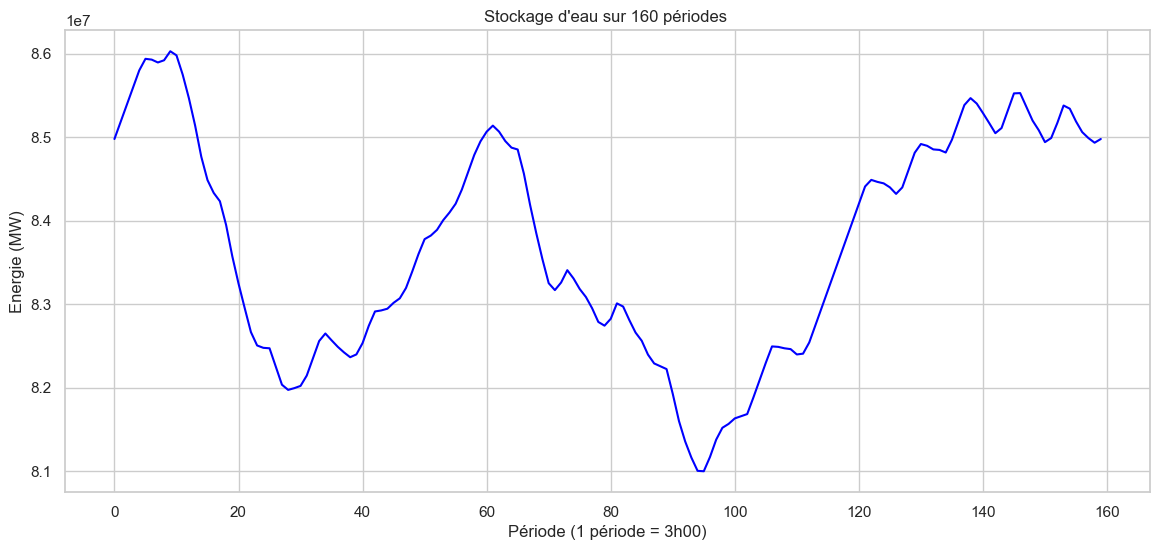

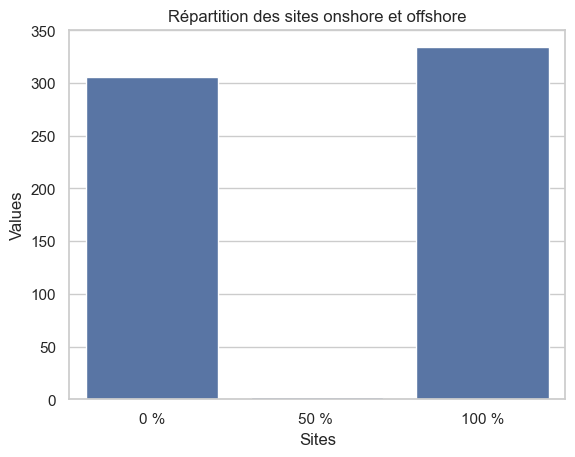

Valeur de la fonction objectif : 143740314.0441831
Valeur du cout moyen (MW/24):  223894.57016227898
Valeur du cout moyen (MW/h):  9328.94042342829
Valeur de la fonction objectif : 656196979.0593455
Valeur du cout moyen (MW/62):  1022113.6745472671
Valeur du cout moyen (MW/h):  16485.70442818173
Valeur de la fonction objectif : 1257406058.2695897
Valeur du cout moyen (MW/100):  1958576.4147501397
Valeur du cout moyen (MW/h):  19585.764147501395
Valeur de la fonction objectif : 1891567215.754505
Valeur du cout moyen (MW/138):  2946366.379679914
Valeur du cout moyen (MW/h):  21350.48101217329
Valeur de la fonction objectif : 2334556647.798231
Valeur du cout moyen (MW/176):  3636381.0713368086
Valeur du cout moyen (MW/h):  20661.25608714096
Valeur de la fonction objectif : 2975477735.8591156
Valeur du cout moyen (MW/214):  4634700.52314504
Valeur du cout moyen (MW/h):  21657.479080117006
Valeur de la fonction objectif : 3581284035.173433
Valeur du cout moyen (MW/252):  5578324.042326219
V

C:\Users\guera\AppData\Local\Temp\ipykernel_2324\53872801.py:79: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 4*10**3)


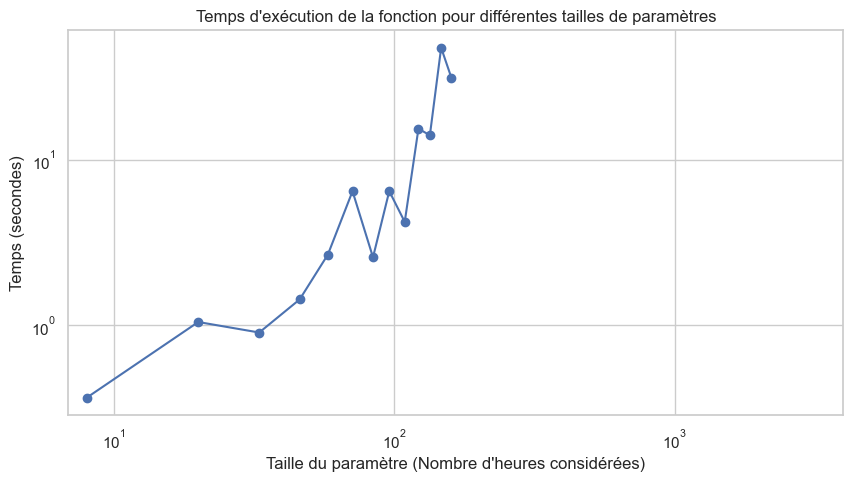

In [ ]:
Data = FichierData2(chemin_sites , chemin_offshore ,chemin_onshore   , chemin_consomation , chemin_apport  )
temps = 24*20
n2 = 0.85
x , a , b , s ,y , z= mod5(Data , n2   , Nombre_sites ,temps , C_Ion , C_Ioff ,turbinage , pompage) 
plot_energy_consumption(s, np.arange(0, temps//3  , 1) , f'Stockage d\'eau sur {temps//3} périodes ' , 'Période (1 période = 3h00)' , 'Energie (MW)')
graphe_battonet(a , b , 'Répartition des sites onshore et offshore' , 'Sites')
measure_and_plot_runtimes(mod5,np.linspace(24, temps  , 13 , dtype=int) , Data , n2 , Nombre_sites ,temps , C_Ion , C_Ioff ,turbinage , pompage)


## Question 6 

On va rajouter une variable d'installation et de production des centrales à gaz. La première sera cgi (centrale à gaz installation) et cgp (centrale à gaz production). En partant du principe qu'on ne peut pas produire plus d'énergie que l'on en a installé en terme d'installation de centrale à gaz 

In [ ]:
def mod6 (Data , n  , Nombre_sites ,Periode , C_Ion , C_Ioff ,turbinage , pompage, C_gaz , C_gaz_heure): 
    Ron = Data.extract_on() #On extrait les données pour les Rendements Onshore
    Roff = Data.extract_off() #On extrait les données pour les Rendements offShore
    Nbre_offshore = len(Roff) #On extrait le nombre de Site offshore 
    Nbre_onshore = len(Ron)
    Nbre_heure = Periode   #Le nombre d'heures total dans une année 365 * 24
    c = Data.extract_Capacite() #On extrait les capacitées 
    
    C_Ion = ((C_Ion )/(365*24) )* Nbre_heure
    C_Ioff = (C_Ioff /(365*24))* Nbre_heure
    C_gaz = (C_gaz /(365*24))* Nbre_heure

    #On commence par créer la fonction objectif : 
    #Creation des variables donc qu'on ne connait pas encore : 
    x_on = cp.Variable( Nbre_onshore ,nonneg = True)  # Variables pour les sites éoliens onshore
    x_of = cp.Variable( Nbre_offshore, nonneg = True)  # Variables pour les sites éoliens offshore
    y = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau minimal de production d'énergie (pompage)
    z = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau maximal de production d'énergie (turbinage)
    s = cp.Variable(Nbre_heure//3,nonneg = True)  # Variable pour le niveau de production d'énergie
    cgi = cp.Variable(1,nonneg = True)  # Variable pour le niveau d'installation de centrale a gaz
    cgp = cp.Variable(Nbre_heure//3 ,nonneg = True)  # Variable pour le niveau de production de centrale a gaz
    
    #Fonction objectif : 
    objective = cp.Minimize(cp.sum(C_Ion * x_on) +
                        cp.sum(C_Ioff * x_of) + cgi * C_gaz + cp.sum(cgp * C_gaz_heure))      # Coûts d'investissement des sites éoliens
    
    #En suite on fait les contraintes : 
    #Initialisation des matrix pour les contraintes :
    Ron = np.transpose(Ron)[:Nbre_heure] #Matrice avec 8760 lignes et 487 colonnes
    Roff = np.transpose(Roff)[:Nbre_heure] #Matrice avec 8760 lignes et 155 colonnes
    # Initialiser la nouvelle matrice avec la première ligne inchangée
    num_new_rows = len(Ron) // 3
    new_Ron = np.zeros((num_new_rows, Ron.shape[1]), dtype=float)

    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Ron)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Ron[i] = np.sum(Ron[start_index:end_index], axis=0)
    num_new_rows = len(Roff) // 3
    new_Roff = np.zeros((num_new_rows, Roff.shape[1]), dtype=float)

    # Calculer les sommes des groupes de trois lignes après la première
    for i in range(len(new_Roff)):
        start_index = 3 * i
        end_index = start_index + 3
        new_Roff[i] = np.sum(Roff[start_index:end_index], axis=0)
    
    #Matrice de Demande 
    D = np.transpose(Data.extract_conso())[:Nbre_heure]
    D = np.sum(D, axis=1)
    
    new_D = []
    sum = 0
    for i in range(len(D)) :
        sum += D[i]
        if i % 3 == 2:
            new_D.append(sum)
            sum = 0

    #Matrice des bassins 
    A = np.transpose(Data.extract_apport())[:Nbre_heure]
    A = np.sum(A, axis=1)
    
    new_A = []
    sum = 0
    for i in range(len(A)) : 
        sum += A[i]
        if i % 3 == 2:
            new_A.append(sum)
            sum = 0
    
    #Matrice de stockage totale 
    S = [0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]    
    sum_pompage = cp.sum(pompage)*3
    sum_turbinage = cp.sum(turbinage)*3
    sum_S = cp.sum(S)
    Ron = Ron[::3]
    Roff = Roff[::3]

    matrix = -np.eye(Nbre_heure//3) + np.eye(Nbre_heure//3, k=1)
    matrix = matrix[:-1]
    Constraints = [s[0] == sum_S*0.5,
                   s[Nbre_heure//3 - 1] == sum_S*0.5,
                   new_Ron @ x_on + new_Roff @ x_of - y + n*z + cgp>= new_D,
                   s <= sum_S*3,
                   y <= sum_pompage,
                   z <= sum_turbinage,
                   x_on <= c[:Nbre_onshore],
                   x_of <= c[Nbre_onshore:],
                   matrix @ s == - z[1:] + y[1:] + new_A[1:],
                   cgp <=3*cgi] 
        
    problem = cp.Problem(objective, Constraints)
    print(cp.installed_solvers())
    problem.solve(solver=cp.SCIPY , scipy_options={"method": "highs"})
    
    print("Valeur de la fonction objectif :", problem.value)
    a = x_on.value
    b = x_of.value
    print(f"Valeur du cout moyen (MW/{Periode}): " ,problem.value/(np.sum(a) + np.sum(b)))
    print(cgi.value)
    print(f"Valeur du cout moyen (euros/MWh): " ,(problem.value/(np.sum(a) + np.sum(b) + np.sum(cgp.value)))/Periode)

    
    return problem.value , a , b , s.value ,y.value , z.value , cgi.value , cgp.value

### Execution de la Question 6 

['CBC', 'CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIP', 'SCIPY', 'SCS']
Valeur de la fonction objectif : 119551364302.1026
Valeur du cout moyen (MW/8760):  210688.5956468843
[74492.94154172]
Valeur du cout moyen (euros/MWh):  0.18798245295752244


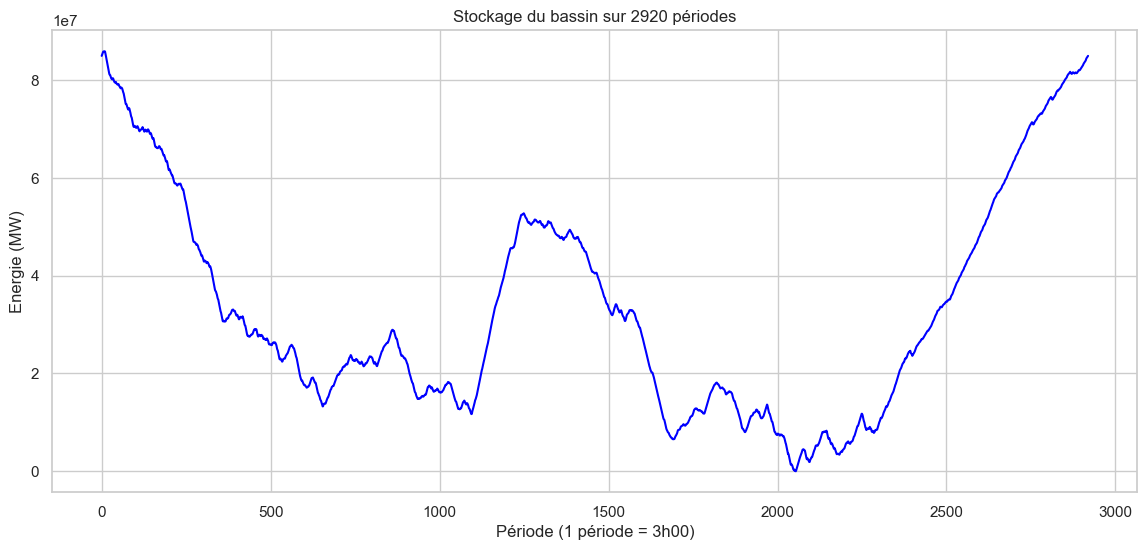

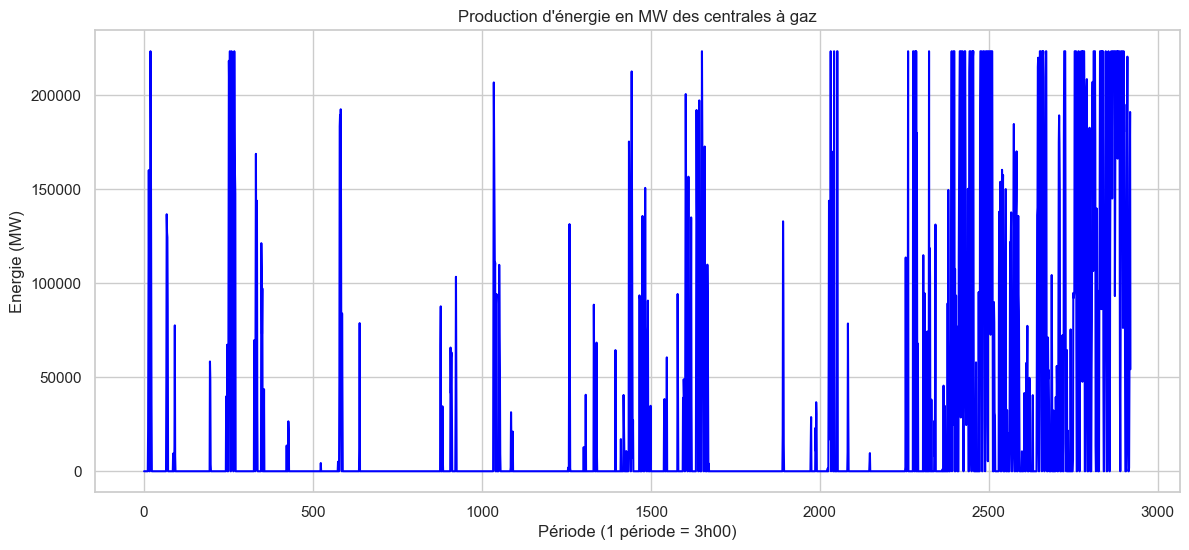

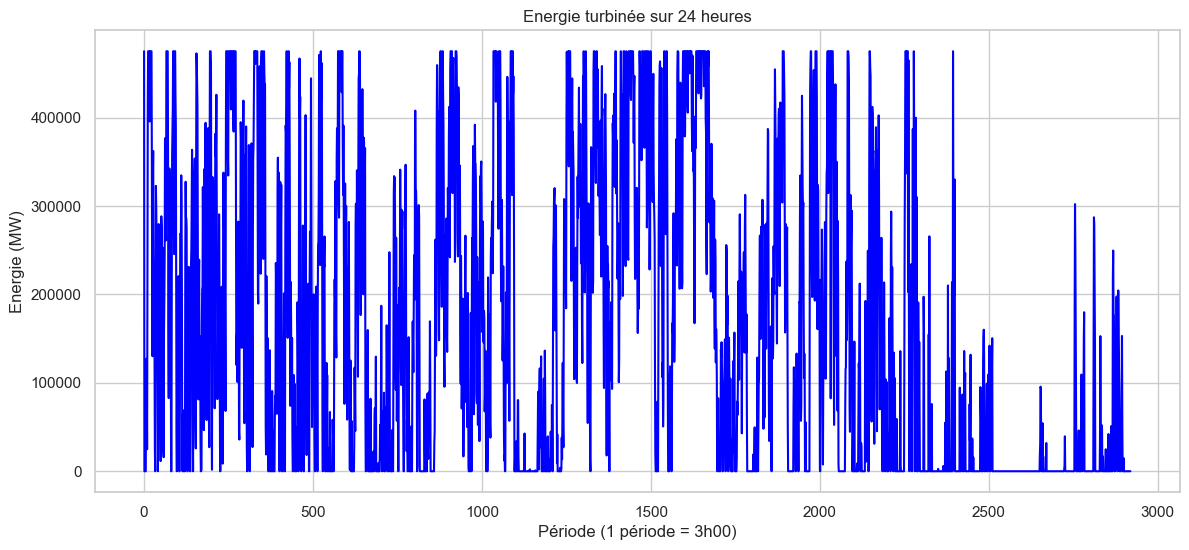

TypeError: measure_and_plot_runtimes() takes 10 positional arguments but 12 were given

In [ ]:
temps = 24*365
n2 = 0.85
x , a , b , s ,y , z , cgi , cgp = mod6(Data , n2  , Nombre_sites ,temps  , C_Ion , C_Ioff ,turbinage , pompage , Cout_gaz , Cout_gaz_heure)

plot_energy_consumption(s, np.arange(0, temps//3  , 1) , f'Stockage du bassin sur {temps//3} périodes' , 'Période (1 période = 3h00)' , 'Energie (MW)')
plot_energy_consumption(cgp, np.arange(0, temps//3  , 1) , 'Production d\'énergie en MW des centrales à gaz' , 'Période (1 période = 3h00)' , 'Energie (MW)')
plot_energy_consumption(z , np.arange(0,temps//3 , 1), 'Energie turbinée sur 24 heures' , 'Période (1 période = 3h00)' , 'Energie (MW)')
